In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install --no-index scikit-learn
# !pip install --no-index seaborn
!pip install --no-index pandas numpy

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic


In [15]:
import numpy as np
from scipy import stats
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from decode_utils import decode, get_percent_correct_from_proba, get_fa, get_dprime, get_train_test_indices
from tqdm import tqdm
from scipy.stats import zscore, norm
import h5py
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from scipy.stats import zscore, norm
from sklearn import preprocessing
import os
from datetime import datetime
import json
import logging

In [11]:
import h5py
import numpy as np
import os

def load_h5_file(file_path, recover=True):
    """
    Load and read data from an H5 file with recovery options.
    
    Args:
        file_path (str): Path to the .h5 file
        recover (bool): Whether to attempt recovery of corrupted file
        
    Returns:
        dict: Dictionary containing the datasets from the file
    """
    data = {}
    
    # First try with error recovery mode
    if recover:
        try:
            with h5py.File(file_path, 'r', driver='core', backing_store=False) as f:
                print("Successfully opened file in recovery mode")
                for key in f.keys():
                    try:
                        data[key] = f[key][:]
                        print(f"Successfully loaded dataset: {key}")
                    except Exception as e:
                        print(f"Warning: Could not load dataset {key}: {e}")
                return data
        except Exception as e:
            print(f"Recovery mode failed: {e}")
    
    # If recovery failed or wasn't requested, try standard mode
    try:
        with h5py.File(file_path, 'r') as f:
            for key in f.keys():
                data[key] = f[key][:]
        return data
    except Exception as e:
        print(f"Standard mode failed: {e}")
        
    # If both methods fail, try to get file info
    try:
        file_size = os.path.getsize(file_path)
        print(f"\nFile diagnostics:")
        print(f"File size: {file_size} bytes")
        print(f"File exists: {os.path.exists(file_path)}")
        print(f"File is readable: {os.access(file_path, os.R_OK)}")
        
        # Try to read raw bytes to check if file is truncated
        with open(file_path, 'rb') as f:
            header = f.read(8)
            if header.startswith(b'\x89HDF\r\n\x1a\n'):
                print("File has valid HDF5 header signature")
            else:
                print("File does not have valid HDF5 header signature")
    except Exception as e:
        print(f"Could not perform file diagnostics: {e}")
    
    raise Exception("Failed to load H5 file through all available methods")

# Example usage with error handling
# if __name__ == "__main__":
file_path = "muri1320_resnet50_diffInitRes0_IT.h5"
models_feature = None
try:
    # Try to load with recovery mode
    data = load_h5_file(file_path, recover=True)
    print("\nSuccessfully loaded datasets:")
    for key, value in data.items():
        print(f"{key}: Shape {value.shape}, Type {value.dtype}")

    models_feature = value.copy()
except Exception as e:
    print(f"\nError: {e}")
    print("\nPossible solutions:")
    print("1. Check if the file was properly closed when it was created")
    print("2. Try to recreate the HDF5 file")
    print("3. Use h5repack tool to repair the file: h5repack input.h5 output.h5")
    print("4. Check if you have sufficient permissions to read the file")

Successfully opened file in recovery mode
Successfully loaded dataset: features

Successfully loaded datasets:
features: Shape (1320, 100352), Type float32


In [20]:
class I1Calculator:
    def __init__(self, features):
        self.logger = self._setup_logger()
        self.lb = ['bear', 'elephant', 'person', 'car', 'dog', 'apple', 'chair', 'plane', 'bird', 'zebra']
        self.features = features
        
    def _setup_logger(self):
        """Set up a logger for debugging."""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            filename='ml_debug.log'
        )
        return logging.getLogger('MLDebug')
    
    def analyze_single(self):
        """Analyze a single condition."""
        # Load and prepare features
        features, labels = self._load_features()
        nrImages = features.shape[0]
        features = features.reshape(nrImages, -1)
        
        # Initialize result array
        i_1 = np.zeros((nrImages, 20), dtype=float)
        i_1[:] = np.NAN
        
        # Perform decoding iterations
        for j in tqdm(range(20), desc=f""):
            p = self._decode(features, labels, seed=j, nrfolds=3)
            pc = self._get_percent_correct(p, labels)
            i_1[:,j] = np.nanmean(pc, axis=1)
        
        overall_accuracy = np.nanmean(i_1)
        return i_1, overall_accuracy
    
    def _load_features(self):
        """Load features from file."""
        final_labels = [label for label in self.lb for _ in range(132)]

        return self.features, np.array(final_labels)
    
    def _decode(self, features, labels, nrfolds=3, seed=0):
        """Perform decoding while preserving relative scales."""
        classes = np.unique(labels)
        nrImages = features.shape[0]
        
        # Center features but preserve scale
        features = features - np.mean(features, axis=0, keepdims=True)
        
        # Initialize probability array
        prob = np.zeros((nrImages, len(classes)))
        prob[:] = np.NAN
        
        # Perform cross-validation
        for i in range(nrfolds):
            train, test = get_train_test_indices(nrImages, nrfolds=nrfolds, foldnumber=i, seed=seed)
            
            # Train classifier
            clf = LogisticRegression(
                penalty='l2',
                C=1.0,
                max_iter=1000,
                class_weight='balanced'
            ).fit(features[train], labels[train])
            
            # Predict probabilities
            prob[test] = clf.predict_proba(features[test])
        
        return prob
    
    def _get_percent_correct(self, prob, labels):
        """Calculate percent correct from probabilities."""
        return get_percent_correct_from_proba(prob, labels, np.array(self.lb))


i1_calculator = I1Calculator(models_feature)

In [21]:
i_1, overall_accuracy = i1_calculator.analyze_single()

100%|██████████| 20/20 [04:03<00:00, 12.17s/it]


In [22]:
sabine_i1_features = np.load("resnet50_i1.npy")

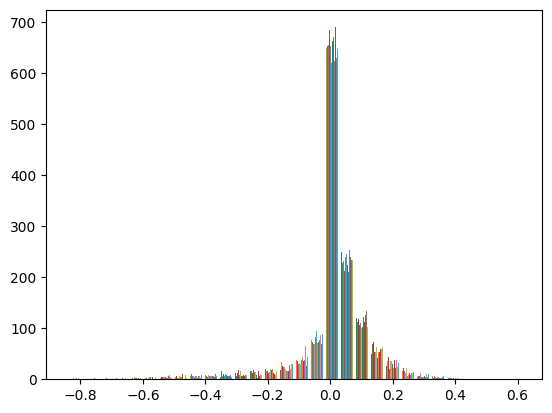

In [32]:
plt.hist(sabine_i1_features - i_1, bins=30)
plt.show()

In [ ]:
np.save("soroush_resnet50_i1.npy", i_1)